# Lab 3 Kanjonavo Sabud

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import chi2

## Part 1: The Invariant Mass Distribution

In [2]:
# importing the dataset
df = pd.read_csv('atlas_z_to_ll.csv',header=None,names=['pT1','pT2','eta1','eta2','phi1','phi2','E1','E2'])
df = df.apply(pd.to_numeric, errors='coerce')  
df = df.dropna().reset_index(drop=True)

# x component calcs for particle
px1 = df['pT1']*np.cos(df['phi1'])
px2 = df['pT2']*np.cos(df['phi2'])
px_tot = px1 + px2

# y component calcs for particle
py1 = df['pT1'] * np.sin(df['phi1'])
py2 = df['pT2'] * np.sin(df['phi2'])
py_tot = py1 + py2

# z component calcs for particle
pz1 = df['pT1'] * np.sinh(df['eta1'])
pz2 = df['pT2'] * np.sinh(df['eta2'])
pz_tot = pz1 + pz2

# Energy calcs for particle
E_tot = df['E1'] + df['E2']

# Invariant mass calcs
m_inv = np.sqrt(E_tot**2 - (px_tot**2+py_tot**2+pz_tot**2))

# getting the bins, centers and errors
counts, bins = np.histogram(m_inv, bins=40, range=(80,100))
centers = 0.5*(bins[:-1] + bins[1:])
errors = np.sqrt(counts)
bin_width = bins[1]-bins[0]

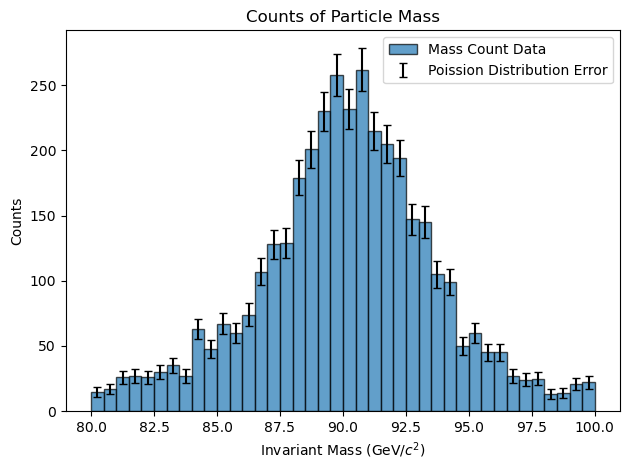

In [3]:
# preliminary plot
fig, ax = plt.subplots()
ax.bar(centers, counts, width=bins[1]-bins[0], edgecolor='k', alpha=0.7,label="Mass Count Data")
ax.errorbar(centers, counts, yerr=errors, fmt='none', ecolor='k', capsize=3, label="Poission Distribution Error")

ax.legend()
ax.set(xlabel='Invariant Mass (GeV/$c^2$)',ylabel='Counts',title='Counts of Particle Mass')

plt.tight_layout()
plt.show()

## Part 2: Breit-Wigner Fit

In [4]:
# defining the model
def model(m, m0, Gamma): return 5000/2*(Gamma/(2*np.pi))/((m-m0)**2+(Gamma/2)**2)

# masking and defining x_fit, y_fit and yerr_fit
mask = (centers > 87) & (centers < 93)
x_fit, y_fit, yerr_fit = centers[mask], counts[mask], errors[mask]

# initial guess for curve fit
p0 = [91.2, 2.5]

# running teh curve fit and getting the best parameters and associated statistical uncertainties
popt, pcov = curve_fit(model, x_fit, y_fit, p0=p0, sigma=yerr_fit, absolute_sigma=True)
m0_fit, Gamma_fit = popt
m0_err, Gamma_err = np.sqrt(np.diag(pcov))

print(f"m0 fit: {m0_fit} +/- {m0_err} GeV/c^2")
print(f"Gamma fit: {Gamma_fit} +/- {Gamma_err} GeV/c^2")

m0 fit: 90.34080575483463 +/- 0.09351489196561226 GeV/c^2
Gamma fit: 6.390998573954562 +/- 0.18107393752279483 GeV/c^2


In [5]:
# statistical analysis
resid_norm = (y_fit - model(x_fit, *popt)) / yerr_fit
chi2_val = np.sum(resid_norm**2)
ndof = x_fit.size - len(popt)
red_chi2 = chi2_val / ndof
p_val = chi2.sf(chi2_val, ndof)

print(f"Chi Square Score: {chi2_val}")
print(f"Degrees of Freedom: {ndof}")
print(f"Reduced Chi Square Score: {red_chi2}")
print(f"P Value: {p_val}")

Chi Square Score: 9.985097164261212
Degrees of Freedom: 10
Reduced Chi Square Score: 0.9985097164261212
P Value: 0.44180173856294824


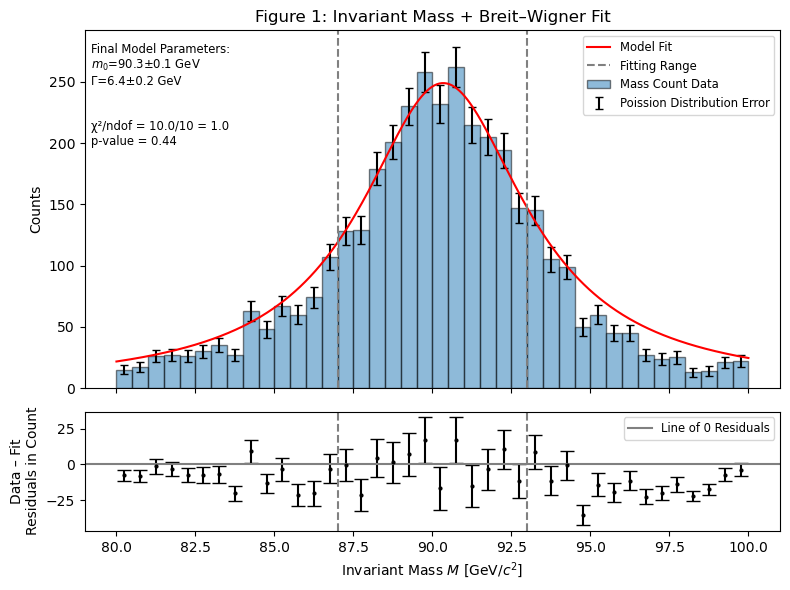

In [6]:
# making the plot grid and getting model results
m_plot  = np.linspace(80, 100, 500)
fit_vals = model(m_plot, *popt)

# Figure 1 Plots
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True,gridspec_kw={'height_ratios':[3,1]},figsize=(8,6))

ax1.bar(centers,counts,width=bin_width,alpha=0.5,edgecolor='k', label="Mass Count Data")
ax1.errorbar(centers, counts, yerr=errors, fmt='none', ecolor='k', capsize=3, label="Poission Distribution Error")
ax1.plot(m_plot, fit_vals, 'r-',label="Model Fit")
ax1.axvline(87,ls='--', c='gray', label="Fitting Range") 
ax1.axvline(93,ls='--', c='gray')
ax1.set_ylabel('Counts')
ax1.set_title('Figure 1: Invariant Mass + Breit–Wigner Fit')
ax1.legend(loc='upper right', fontsize='small')

resid = counts - model(centers, *popt)
ax2.errorbar(centers, resid, yerr=errors, capsize=5, fmt='.k', ms=4)
ax2.axvline(87, ls='--', c='gray') 
ax2.axvline(93, ls='--', c='gray')
ax2.axhline(0, c='gray', label="Line of 0 Residuals")
ax2.set_xlabel('Invariant Mass $M$ [GeV/$c^2$]')
ax2.set_ylabel('Data – Fit\nResiduals in Count')
ax2.legend(fontsize='small')

fig.text(0.12, 0.85,f"Final Model Parameters:\n$m_0$={m0_fit:.1f}±{m0_err:.1f} GeV\nΓ={Gamma_fit:.1f}±{Gamma_err:.1f} GeV",fontsize='small')
fig.text(0.12, 0.75,f"χ²/ndof = {chi2_val:.1f}/{ndof} = {red_chi2:.1f}\np-value = {p_val:.2f}",fontsize='small')

plt.tight_layout()
plt.show()

## Part 3: 2D Parameter Contours

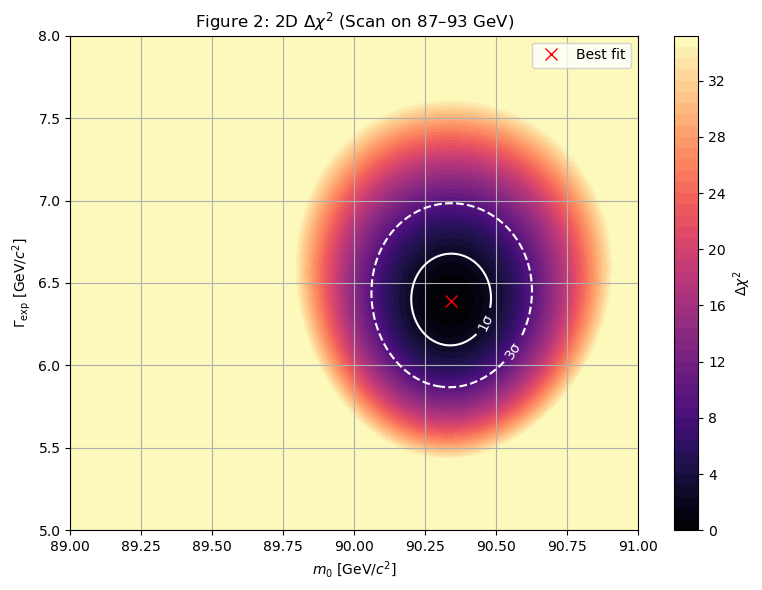

In [7]:
# meshgrid init for Figure 2 plot
m0_vals = np.linspace(89,91,300)
gamma_vals = np.linspace(5,8,300)
M0, GG = np.meshgrid(m0_vals, gamma_vals)
chi2_grid = np.zeros_like(M0)

for i, m0 in enumerate(m0_vals):
    for j, G in enumerate(gamma_vals):
        pred = model(x_fit, m0, G)
        chi2_grid[j,i]= np.sum(((y_fit-pred)/yerr_fit)**2)

dchi2 =chi2_grid-chi2_grid.min()
dchi2 =np.clip(dchi2,0,35) #clipping at 35

fig, ax = plt.subplots(figsize=(8,6))
cf = ax.contourf(M0, GG, dchi2, levels=50,cmap='magma')
cbar = fig.colorbar(cf, ax=ax)
cbar.set_label(r'$\Delta\chi^2$')

levels = [2.30, 9.21] # should the 3 sigma line be 11.83
cs = ax.contour(M0, GG, dchi2, levels=levels,colors='white',linestyles=['solid','dashed'],linewidths=1.5)
ax.clabel(cs, fmt={2.30:'1σ', 9.21:'3σ'}, inline=True, fontsize=10)

ax.plot(m0_fit, Gamma_fit, 'rx', ms=8, label='Best fit')

ax.set_title('Figure 2: 2D $\\Delta\\chi^2$ (Scan on 87–93 GeV)')
ax.set_xlabel(r'$m_0$ [GeV/$c^2$]')
ax.set_ylabel(r'$\Gamma_\mathrm{exp}$ [GeV/$c^2$]')
ax.legend(loc='upper right')

plt.tight_layout()
plt.grid()
plt.show()